## Look at correlations between ASC and cross slope heat transport across different spatial scales (e.g. single basins)

In [2]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from dask.distributed import Client
import matplotlib.colors as col

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [3]:
client = Client(memory_limit='240gb',n_workers=48)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 10.48 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36379,Workers: 48
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 10.48 TiB
Comm: tcp://127.0.0.1:42921,Total threads: 1
Dashboard: /proxy/34091/status,Memory: 223.52 GiB
Nanny: tcp://127.0.0.1:44023,


2025-07-04 15:14:28,382 - distributed.scheduler - ERROR - Couldn't gather keys: {('where-7b9a7526da3ca845d596ee9b6bca6a4a', 0): 'forgotten'}


In [4]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

exp = '01deg_jra55v140_iaf_cycle3'
start_time= '1958-01-01'
end_time= '2018-12-31'
lat_range = slice(-90,-59)
isobath_depth = 1000

session = cc.database.create_session()

In [5]:
ht = cc.querying.getvar(exp,'ht' , master_session,n=1)


## First open u_along in density layers to use for compositing, and to show in time series:

In [6]:
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_10deg_bin.nc')

# resample monthly:
u_along_da_months = u_along.resample(time='1M').mean()#.U_along_contour_binned
u_along_da_months = u_along_da_months.sel(potrho0=slice(13.8,28.42))#.rename({'lon_bin_midpoints': 'lon'})
u_along_da_months.load();

####################

# load monthly water mass mask:
age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')

# select out CDW layer:
u_along_da_months_binned_CDW = (age_mask.CDW_mask*u_along_da_months)

####################

# get volume for averaging across density layers:
vol_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Volume_rho_10deg_bins.nc')

# do volume-weighted density average and annual averaging:
def vol_ave_potrho0_potmask(quantity,vol_bins):
    return (quantity * vol_bins.volume).mean('potrho0')/vol_bins.mean('potrho0').volume

U_along_annual_binned_CDW_volav = vol_ave_potrho0_potmask(u_along_da_months_binned_CDW,vol_bins).groupby('time.year').mean('time')
U_along_annual_binned_CDW_volav = U_along_annual_binned_CDW_volav.load()
# climatological averaging and sum over layers:
U_along_clima_binned_CDW_volav = vol_ave_potrho0_potmask(u_along_da_months_binned_CDW,vol_bins).groupby('time.month').mean('time')
U_along_clima_binned_CDW_volav = U_along_clima_binned_CDW_volav.load()

## Then open CSHT in density layers for time series:

In [7]:
# Load CSHT field
CSHT_along = xr.open_mfdataset('/g/data/e14/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc')

# resample monthly:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()

# apply age mask to select out CDW layer:
CSHT_months_binned_CDW = (age_mask.CDW_mask * CSHT_along_monthly )

# annual averaging and sum over layers:
CSHT_annual_binned_CDW = CSHT_months_binned_CDW.groupby('time.year').mean('time').sum(dim = 'potrho0')
# climatological averaging and sum over layers:
CSHT_clima_binned_CDW = CSHT_months_binned_CDW.groupby('time.month').mean('time').sum(dim = 'potrho0')

## Now open correlation data to check we're selecting the correct longitude bin:

In [8]:
files_path = '/g/data/e14/qo9901/ASC_collab_CSHT_ds/'
file_extension = 'agemaskCDW_volav_corr'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()

high_corr_lons = r_sq_annual_10deg.where(r_sq_annual_10deg>0.3,drop=True).lon_bins.values

(-195.0, -160.0)

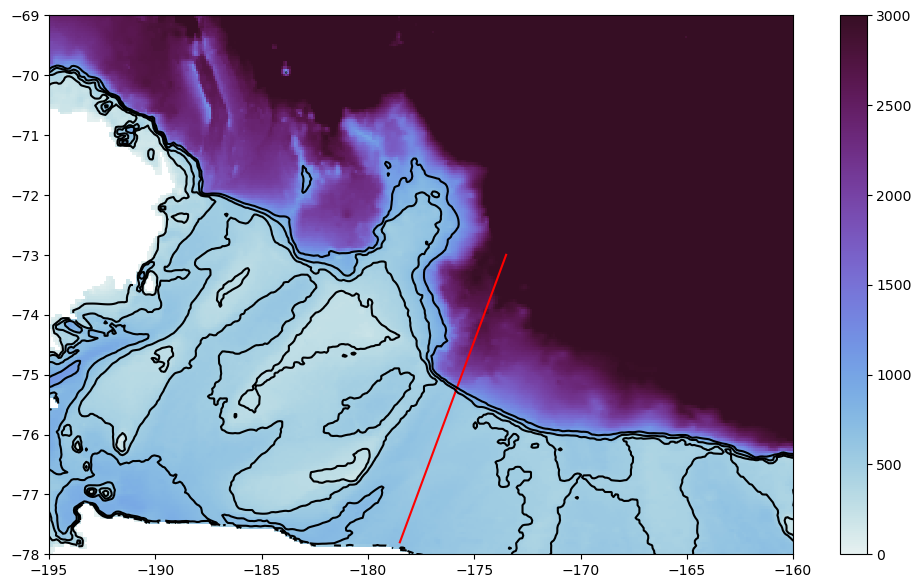

In [9]:
# check location of transect is good:

# new diagonal, cross-shelf transect:

# define transect start and end points:
lat1 = -77.8
lat0= -73
lon1 = -178.5
lon0 = -173.5

plt.figure(figsize=(12,7))

# plot temperature:
plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,cmap=cmocean.dense)
plt.colorbar()
plt.clim((0,3000))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r')

# plot bathymetry contours:
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[300,500,700,1000],colors='k')

plt.ylim(-78,-69)
plt.xlim(-195,-160)

In [75]:
lons = [lon1, lon0]
lats = [lat1, lat0]

yt_ocean = ht.yt_ocean
# get latitude of points along transect:
lat_transect = yt_ocean.sel(yt_ocean = slice(lats[0],lats[1])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect_t = xr.DataArray(lon_transect, dims = 'yt_ocean')
lon_transect_u = xr.DataArray(lon_transect, dims = 'yu_ocean')

# convert to xarray:
lat_transect_t = xr.DataArray(lat_transect, dims = 'yt_ocean')
lat_transect_u = xr.DataArray(lat_transect, dims = 'yu_ocean')


## Find years when CDWlayer u_along is strongly westward (or less eastward):

In [76]:
longitude_slices = np.array([-63.5,-133.5, -173.5])

## Check if high_correlation lons align with the regions we have selected:
print(np.isin(longitude_slices,high_corr_lons))
regions = ['West Antarctic Peninsula', 'Getz', 'Glomar_angled']

min_lat = np.append(np.array([-69, -74.25]), lat0)

vmin_range = np.array([-.2, -.05, -.05])
# for temp:
norm = [col.Normalize(vmin=-1.9,vmax=2.6),
col.Normalize(vmin=-1.8,vmax=1.5), 
col.Normalize(vmin=-1.8,vmax=1.5)]

levels=[np.arange(-1.9,2.6,.05), 
        np.arange(-1.8,1.55,.05), 
        np.arange(-1.8,1.55,.05)]
ticks = [[-1,0,1,2], [-1,0,1], [-1,0,1]]



[ True  True  True]


In [77]:
# import bathymetry:
hu_transect_og = cc.querying.getvar(exp,'hu',session,n=1)
temp_og = cc.querying.getvar(exp, 'temp', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12}) - 273.15
rho_og = cc.querying.getvar(exp, 'pot_rho_0', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12})
u_og = cc.querying.getvar(exp, 'u', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12})

In [93]:
##########################
hu_transect_list = []
hu_sliced_list = []
max_lat = []
southward_threshold = []
northward_threshold = []
temp_southward = []
temp_northward = []
rho_southward = []
rho_northward = []
u_southward = []
u_northward = []

longitude_slices_10dg = [-63.5,-133.5, -173.5]
for i in tqdm(range(longitude_slices.size)):
    print(i)
    # select out longitude:
    u_along_regional = U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices_10dg[i])
    
    # find u_along threshold for most southward 100 months:
    u_sorted = u_along_regional.sortby(u_along_regional)
    npoints = 10
    southward_threshold.append(u_sorted[npoints].data) #negative, westward threshold for ASC
    northward_threshold.append(u_sorted[-npoints].data) #Positive, eastward threshold for ASC

    ## NOTE: We are now averaging over ten longitude bins

    # import bathymetry:
    if i<2:
        hu_sliced = hu_transect_og.sel(xu_ocean=longitude_slices[i], method='nearest').sel(yu_ocean=lat_range)
        hu_transect = hu_transect_og.sel(xu_ocean=slice(longitude_slices[i]-5, longitude_slices[i]+5)).mean('xu_ocean').sel(yu_ocean=lat_range)
    else:
        hu_sliced = hu_transect_og.sel(xu_ocean=lon_transect_u, yu_ocean = lat_transect_u, method='nearest')

    # fill nans with zeros:
    hu_transect = hu_transect.where(hu_transect>0,0)
    hu_sliced = hu_sliced.where(hu_sliced>0,0)
    hu_transect_list.append(hu_transect)
    hu_sliced_list.append(hu_sliced)
    
    # find latitude limits for plot:
    # lats = (hu_transect.yu_ocean).where(hu_transect>0).compute()
    #min_lat = lats.dropna('yu_ocean').data[0]-.1
    #lats = (hu_transect.yu_ocean).where(hu_transect>3000).compute()
    if i<2:
        lats_2 = (hu_sliced.yu_ocean).where(hu_sliced>3000).compute()
        max_lat.append(lats_2.dropna('yu_ocean').data[0])
    else:
        max_lat.append(lat0)
    if i<2:
        # Use monthly data to pick southward times:
        temp = temp_og.sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude_slices[i], method='nearest')\
                                                                           .sel(st_ocean=slice(0,1300)).sel(yt_ocean=lat_range)
        temp = temp.groupby('time.year').mean().load()
        
        temp_southward.append(temp.where(u_along_regional < southward_threshold[i]).mean('year').load())
        temp_northward.append(temp.where(u_along_regional > northward_threshold[i]).mean('year').load())
        
        rho = rho_og.sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude_slices[i], method='nearest')\
                                                                           .sel(st_ocean=slice(0,1300)).sel(yt_ocean=lat_range)
        rho = rho.groupby('time.year').mean().load()
        
        rho_southward.append(rho.where(u_along_regional < southward_threshold[i]).mean('year').load())
        rho_northward.append(rho.where(u_along_regional > northward_threshold[i]).mean('year').load())
        
        u = u_og.sel(time=slice(start_time,end_time)).sel(xu_ocean=longitude_slices[i], method='nearest')\
                                                                           .sel(st_ocean=slice(0,1300)).sel(yu_ocean=lat_range)
        u = u.groupby('time.year').mean().load()
        
        u_southward.append(u.where(u_along_regional < southward_threshold[i]).mean('year').load())
        u_northward.append(u.where(u_along_regional > northward_threshold[i]).mean('year').load())
    else:
        temp = temp_og.sel(time=slice(start_time,end_time)).sel(xt_ocean=lon_transect_t, yt_ocean = lat_transect_t, method='nearest')\
                                                                   .sel(st_ocean=slice(0,1300))
        temp = temp.groupby('time.year').mean().load()
        temp_southward.append(temp.where(u_along_regional < southward_threshold[i]).mean('year').load())
        temp_northward.append(temp.where(u_along_regional > northward_threshold[i]).mean('year').load())

        rho = rho_og.sel(time=slice(start_time,end_time)).sel(xt_ocean=lon_transect_t, yt_ocean = lat_transect_t, method='nearest')\
                                                                           .sel(st_ocean=slice(0,1300))
        rho = rho.groupby('time.year').mean().load()
        
        rho_southward.append(rho.where(u_along_regional < southward_threshold[i]).mean('year').load())
        rho_northward.append(rho.where(u_along_regional > northward_threshold[i]).mean('year').load())
        
        u = u_og.sel(time=slice(start_time,end_time)).sel(xu_ocean=lon_transect_u, yu_ocean = lat_transect_u, method='nearest')\
                                                                           .sel(st_ocean=slice(0,1300))
        u = u.groupby('time.year').mean().load()
        
        u_southward.append(u.where(u_along_regional < southward_threshold[i]).mean('year').load())
        u_northward.append(u.where(u_along_regional > northward_threshold[i]).mean('year').load())


  0%|          | 0/3 [00:00<?, ?it/s]

0


 33%|███▎      | 1/3 [01:12<02:24, 72.07s/it]

1


 67%|██████▋   | 2/3 [02:21<01:10, 70.27s/it]

2


100%|██████████| 3/3 [03:00<00:00, 60.29s/it]


In [138]:
arr = np.linspace(-0.03, 0.03, 7)  # Generates 5 points
arr = arr[arr != 0]  # Remove zero
arr

u_levels = [[-.24,-.20,-.16,-.12,-.08,-.04,.04,.08,.12,.16,.20,.24],
            arr, arr]

density_contours = [[1027.65,1027.78,1027.8],
                    [1027.65,1027.78,1027.8,1027.82,1027.83],
                    [1027.65,1027.78, 1027.82]]

In [139]:

# Function x**(1/2)
def forward(x):
    return x**(1/2)


def inverse(x):
    return x**2

In [140]:
# #### UNCOMMENT BELOW TO SEE ALL REGIONS #####

# # plot single longitude:
# # plot:
# fontsize = 12
# min_lats_selected = [-63.5, -74.6, -73]

# for i in range(np.array(regions).size):
#     fig=plt.figure(figsize=(7,6))
#     plt.clf()
    
#     # Northward CSHT:
#     ax1 = fig.add_axes([0.0,0.5,0.9,0.45])
    
#     pcm = ax1.contourf(temp_northward[i].yt_ocean,temp_northward[i].st_ocean,
#                        temp_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
#                        cmap = cmocean.thermal, norm = norm[i],levels=levels[i],extend='both')
#     #ax1.fill_between(temp_southward[i].yt_ocean,hu_transect_list[i],3000,zorder=3,color='darkgrey')
#     ax1.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3,color='darkgrey')

#     ax1.set_yscale('function', functions=(forward, inverse))
#     ax1.set_ylim(1600,0.5)
#     ax1.set_xlim(min_lat[i]-1,max_lat[i]+1)
#     ax1.set_ylabel('Depth (m)',fontsize=fontsize)
#     #ax1.set_xlabel('Longitude',fontsize=fontsize)
#     ax1.set_xticks([])
#     ax1.set_yticks([1200,800,400,100,0.5],labels=[1200,800,400,100,0])
#     plt.tick_params(labelsize=fontsize)
#     ax1.set_title(str(regions[i])+' ('+str(longitude_slices[i])+')\n r-squared: '+str(r_sq_annual_10deg.sel(lon_bins=longitude_slices_10dg[i]).values.round(2)))
    
#     # colorbar:
#     cax = fig.add_axes([0.94,0.5,0.022,0.45])
#     cbar = plt.colorbar(pcm, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks[i])
#     cbar.set_label(r'Temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
#     cbar.ax.tick_params(labelsize=fontsize)

#     cont=ax1.contour(rho_northward[i].yt_ocean,rho_northward[i].st_ocean,
#                      rho_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours[i],
#                       colors='k',zorder=2 ,fontsize=fontsize,linestyles='-')
    
#     cont2=ax1.contour(u_northward[i].yu_ocean,u_northward[i].st_ocean,
#                      u_northward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),u_levels[i],vmin=vmin_range[i],vmax=-vmin_range[i],
#                       cmap=cmocean.delta,zorder=2 ,fontsize=fontsize)
    
#     cont2=ax1.pcolormesh(u_northward[i].yu_ocean,u_northward[i].st_ocean,
#                      u_northward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),vmin=vmin_range[i],vmax=-vmin_range[i],
#                       cmap=cmocean.delta,zorder=0 )

    
#     ax1.text(min_lat[i]-0.99, 1100, '10 weakest\nslope current\nyears', fontsize=15)
#     ####################
    
#     ax2 = fig.add_axes([0.0,0.0,0.9,0.45])
    
#     pcm = ax2.contourf(temp_southward[i].yt_ocean,temp_southward[i].st_ocean,
#                        temp_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
#                        cmap = cmocean.thermal, norm = norm[i],levels=levels[i],extend='both')
#     # ax2.fill_between(temp_southward[i].yt_ocean,hu_transect_list[i],3000,zorder=3,color='darkgrey')
#     ax2.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3,color='darkgrey')

#     ax2.set_yscale('function', functions=(forward, inverse))
#     ax2.set_ylim(1600,0.5)
#     ax2.set_xlim(min_lat[i]-1,max_lat[i]+1)
#     ax2.set_ylabel('Depth (m)',fontsize=fontsize)
#     ax2.set_xlabel('Latitude',fontsize=fontsize)
#     #ax2.set_xticks([-74,-73.5,-73,-72.5])
#     #ax2.set_xticks([-66.5,-66,-65.5,-65])
#     ax2.set_yticks([1200,800,400,100,0.5],labels=[1200,800,400,100,0])
#     plt.tick_params(labelsize=fontsize)
#     ax2.text(min_lat[i]-0.99, 1100, '10 strongest\nslope current\nyears', fontsize=15)
    
#     #ax2.set_title('u_aong westward (or less northward)',fontsize=fontsize)
    
#     # colorbar:
#     cax = fig.add_axes([0.94,0.0,0.022,0.45])
#     cbar = plt.colorbar(cont2, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks[i])
#     cbar.set_label(r'Velocity (m/s)',fontsize=fontsize,labelpad=5)
#     cbar.ax.tick_params(labelsize=fontsize)
    
    
#     cont=ax2.contour(rho_southward[i].yt_ocean,rho_southward[i].st_ocean,
#                      rho_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours[i],
#                       colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    
#     cont2=ax2.contour(u_southward[i].yu_ocean,u_southward[i].st_ocean,
#                      u_southward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),u_levels[i],vmin=vmin_range[i],vmax=-vmin_range[i],
#                       cmap=cmocean.delta,zorder=2 ,fontsize=fontsize)
    
    
#     ###################
    
#     ax3 = fig.add_axes([0.0,-0.5,0.9,0.4])
#     pci = ax3.contourf(temp_southward[i].yt_ocean,temp_southward[i].st_ocean,
#                        temp_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-\
#                         temp_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
#                        cmap = cm.bwr,levels=np.linspace(-1,1,200), vmin=-1, vmax=1, extend='both',fontsize=fontsize)
#     ax3.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3,color='darkgrey')

#     ax3.set_yscale('function', functions=(forward, inverse))
#     ax3.set_ylim(1600,0.5)
#     ax3.set_xlim(min_lats_selected[i],max_lat[i]+2)
#     ax3.set_ylabel('Depth (m)',fontsize=fontsize)
#     ax3.set_yticks([1200,800,400,100,0.5],labels=[1200,800,400,100,0])

#     ax3.set_xlabel('Latitude',fontsize=fontsize)
#     xticklabels = abs(ax3.get_xticks())
#     xticklabels_with_s = [f"{label:.0f}$^\circ$S" for label in xticklabels]  # Format as integers + 'S'
#     ax3.set_xticklabels(xticklabels_with_s)

#     ax3.tick_params(labelsize=fontsize)

#     cont=ax3.contour(rho_northward[i].yt_ocean,rho_northward[i].st_ocean,
#                      rho_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours[i],
#                       colors='k',zorder=2 ,fontsize=fontsize,linestyles='-')
#     cont=ax3.contour(rho_southward[i].yt_ocean,rho_southward[i].st_ocean,
#                      rho_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours[i],
#                       colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')    
#     ################
    
#     # ax4 = fig.add_axes([0.0,-1,0.9,0.4])
#     # ax4_HT=ax4.twinx()
#     # ax4.plot(U_along_clima_binned_CDW_volav.month,U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='ASC')
#     # ax4.plot([1956,2024],[0,0],\
#     #          linestyle='--',color='black')
#     # ax4_HT.plot(U_along_clima_binned_CDW_volav.month,(CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12),\
#     #             label='CSHT',color='tab:orange')
#     # # ax3.set_ylim(u_along_lims[i])
#     # # ax3.set_yticks([-3,-2,-1,0,1,2,3],labels=[-3,-2,-1,0,1,2,3],fontsize=14,color='tab:blue')
#     # ax4.set_ylabel('ASC speed (cm/s)',fontsize=fontsize,color='tab:blue')
#     # # ax3_HT.set_ylim(CSHT_lims[i])
#     # # ax3_HT.set_yticks([-10,-5,0,5,10],labels=[-10,-5,0,5,10],fontsize=14,color='tab:orange')
#     # ax4_HT.set_ylabel('Cross Slope Heat Transport \n (TW)',fontsize=fontsize,color='tab:orange')
#     # ax4.set_xlabel('Month')
#     # # ax4.set_xticks(ticks=np.arange(1960,2021,10),labels=np.arange(1960,2021,10), fontsize=14)
#     # ax4.set_xlim(1,12)
#     # ax4.text(1.25, np.nanmin(U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100)+0.01, 'Climatology', fontsize=15)
    
#     # save:
#     figure_path = figdir+'Transect_'+str(regions[i])+'.png'
#     plt.savefig(figure_path , dpi=300,bbox_inches='tight', pad_inches=0.1,facecolor='white')
#     plt.show()

0
-63.5 -62
[-63.5 -63.  -62.5 -62. ]
['63.0$^\\circ$S', '62.5$^\\circ$S']
1
-74.6 -72.5
[-75.  -74.5 -74.  -73.5 -73.  -72.5]
['74.5$^\\circ$S', '74.0$^\\circ$S', '73.5$^\\circ$S', '73.0$^\\circ$S']
2
-77.8 -73.2
[-78. -77. -76. -75. -74. -73.]
['77.0$^\\circ$S', '76.0$^\\circ$S', '75.0$^\\circ$S', '74.0$^\\circ$S']


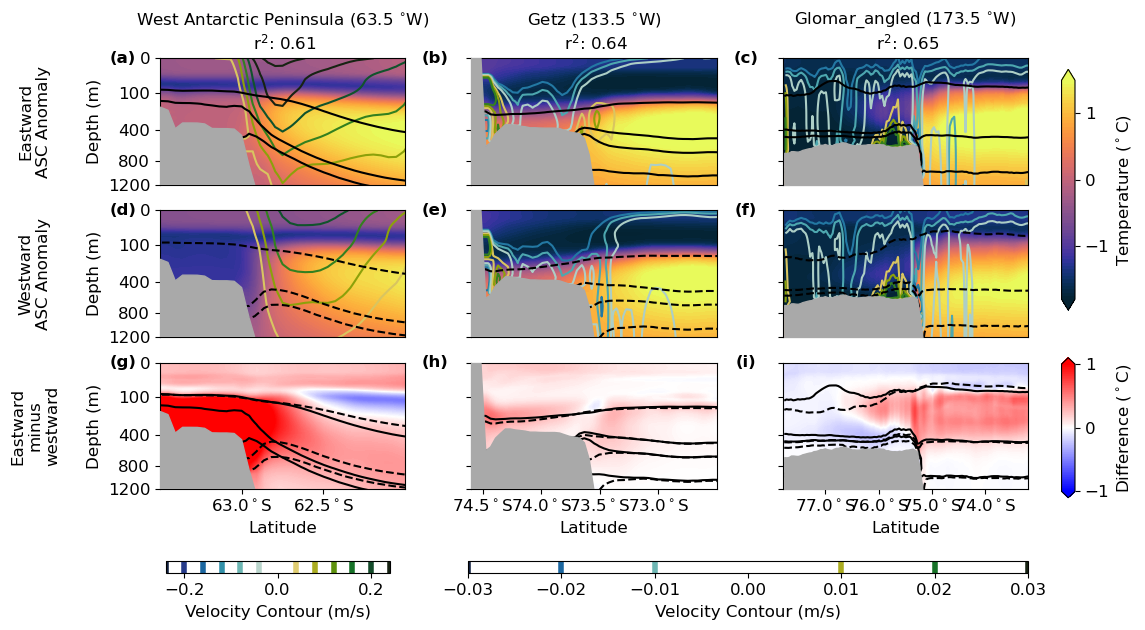

In [154]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib

fontsize = 12

regions_selected = ['Getz', 'West Antarctic Peninsula', 'Glomar_angled']
# Find indices where regions match those in regions_selected
inds_regions = np.where(np.isin(regions, regions_selected))[0]
min_lats_selected = [-63.5, -74.6, lat1]
max_lats_selected = [-62, -72.5, -73.2]# Create a figure
fig = plt.figure(figsize=(16*0.7, 8*0.7))

# Create a GridSpec for a 3x4 grid
grid = gs.GridSpec(nrows=3, ncols=3, figure=fig)
grid.update(hspace=0.2, wspace=0.27)  # Adjust vertical and horizontal spacing

# Initialize a list to store axes
axes = []

subplots = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

# Loop through the 3x4 grid to create subplots
for j in range(inds_regions.size):  # Loop over rows
    ax1 = fig.add_subplot(grid[0, j])
    ax2 = fig.add_subplot(grid[1, j])
    ax3 = fig.add_subplot(grid[2, j])

    i = inds_regions[j]
    print(i)
    pcm = ax1.contourf(temp_northward[i].yt_ocean,temp_northward[i].st_ocean,
                       temp_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm[i],levels=levels[i],extend='both')
    #ax1.fill_between(temp_southward[i].yt_ocean,hu_transect_list[i],3000,zorder=3,color='darkgrey')
    ax1.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax1.set_yscale('function', functions=(forward, inverse))
    ax1.set_ylim(1200,0.5)
    ax1.set_xlim(min_lats_selected[j],max_lats_selected[i])
    if j == 0:
        ax1.set_ylabel('Depth (m)',fontsize=fontsize)
        ax1.set_yticks([1200,800,400,100,0.5],labels=[1200,800,400,100,0])
    else:
        ax1.set_yticks([1200,800,400,100,0.5],labels=[])
    ax1.set_xticks([])
    ax1.set_title(str(regions[i])+' ('+str(abs(longitude_slices[i]))+' $^{\circ}$W'+')\n r$^2$: '+str(r_sq_annual_10deg.sel(lon_bins=longitude_slices[i]).values.round(2)))
    
    # colorbar:
    
    cont=ax1.contour(rho_northward[i].yt_ocean,rho_northward[i].st_ocean,
                     rho_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='-')
    
    cont2=ax1.contour(u_northward[i].yu_ocean,u_northward[i].st_ocean,
                     u_northward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),u_levels[i],vmin=vmin_range[i],vmax=-vmin_range[i],
                      cmap=cmocean.delta,zorder=2 ,fontsize=fontsize)
    
    cont2=ax1.pcolormesh(u_northward[i].yu_ocean,u_northward[i].st_ocean,
                     u_northward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),vmin=vmin_range[i],vmax=-vmin_range[i],
                      cmap=cmocean.delta,zorder=0 )

    ax1.tick_params(labelsize=fontsize)
    ####################
        
    pcm = ax2.contourf(temp_southward[i].yt_ocean,temp_southward[i].st_ocean,
                       temp_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.thermal, norm = norm[i],levels=levels[i],extend='both')
    # ax2.fill_between(temp_southward[i].yt_ocean,hu_transect_list[i],3000,zorder=3,color='darkgrey')
    ax2.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax2.set_yscale('function', functions=(forward, inverse))
    ax2.set_ylim(1200,0.5)
    ax2.set_xlim(min_lats_selected[j],max_lats_selected[i])
    ax2.set_xticks([])
    print(min_lats_selected[j],max_lats_selected[i])

    if j == 0:
        ax2.set_ylabel('Depth (m)',fontsize=fontsize)
    # ax2.set_xlabel('Latitude',fontsize=fontsize)
    #ax2.set_xticks([-74,-73.5,-73,-72.5])
    #ax2.set_xticks([-66.5,-66,-65.5,-65])
        ax2.set_yticks([1200,800,400,100,0.5],labels=[1200,800,400,100,0])
    else:
        ax2.set_yticks([1200,800,400,100,0.5],labels=[])
    
    #ax2.set_title('u_aong westward (or less northward)',fontsize=fontsize)    
    
    cont=ax2.contour(rho_southward[i].yt_ocean,rho_southward[i].st_ocean,
                     rho_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='--')
    
    cont2=ax2.contour(u_southward[i].yu_ocean,u_southward[i].st_ocean,
                     u_southward[i].interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),u_levels[i],vmin=vmin_range[i],vmax=-vmin_range[i],
                      cmap=cmocean.delta,zorder=2 ,fontsize=fontsize)
    ax2.tick_params(labelsize=fontsize)
    #########

    pci = ax3.contourf(temp_southward[i].yt_ocean,temp_southward[i].st_ocean,
                   temp_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate')-\
                    temp_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                   cmap = cm.bwr,levels=np.linspace(-1,1,200), vmin=-1, vmax=1, extend='both',fontsize=fontsize)
    ax3.fill_between(temp_southward[i].yt_ocean,hu_sliced_list[i],3000,zorder=3000,color='darkgrey')

    ax3.set_yscale('function', functions=(forward, inverse))
    ax3.set_ylim(1200,0.5)
    ax3.set_xlim(min_lats_selected[j],max_lats_selected[i])
    if j == 0:
        ax3.set_ylabel('Depth (m)',fontsize=fontsize)
        ax3.set_yticks([1200,800,400,100,0.5],labels=[1200,800,400,100,0])
    else:
        ax3.set_yticks([1200,800,400,100,0.5],labels=[])

    ax3.set_xlabel('Latitude',fontsize=fontsize)
    print(ax3.get_xticks())
    xticklabels = abs(ax3.get_xticks())[1:-1]
    xticklabels_with_s = [f"{label:.1f}$^\circ$S" for label in xticklabels]  # Format as integers + 'S'
    print(xticklabels_with_s)
    ax3.set_xticks(ax3.get_xticks()[1:-1])
    ax3.set_xticklabels(xticklabels_with_s)

    ax3.tick_params(labelsize=fontsize)

    cont=ax3.contour(rho_northward[i].yt_ocean,rho_northward[i].st_ocean,
                     rho_northward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='-')
    cont=ax3.contour(rho_southward[i].yt_ocean,rho_southward[i].st_ocean,
                     rho_southward[i].interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours[i],
                      colors='k',zorder=2000 ,fontsize=fontsize,linestyles='--')

    ax1.text(-0.15,1, subplots[j], fontsize=fontsize, fontweight = 'bold', transform = ax1.transAxes, va = 'center', ha = 'center')
    ax2.text(-0.15,1, subplots[j+3], fontsize=fontsize, fontweight = 'bold', transform = ax2.transAxes, va = 'center', ha = 'center')
    ax3.text(-0.15,1, subplots[j+6], fontsize=fontsize, fontweight = 'bold', transform = ax3.transAxes, va = 'center', ha = 'center')

cax = fig.add_axes([0.93,0.43,0.012,0.43])
cbar = plt.colorbar(pcm, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks[i])
cbar.set_label(r'Temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

cax = fig.add_axes([0.93,0.095,0.012,0.25])
cbar = plt.colorbar(pci, cax=cax,orientation = 'vertical',extend = 'neither',ticks=[-1,0,1])
cbar.set_label(r'Difference ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

# colorbar:
norm_cbar = plt.Normalize(vmin=-.24, vmax = 0.24)
sm = plt.cm.ScalarMappable(cmap=cmocean.delta, norm = norm_cbar)

cax = fig.add_axes([0.13,-0.04,0.2,0.022])
cbar = plt.colorbar(sm, cax=cax,orientation = 'horizontal',extend = 'neither')
cbar.set_label(r'Velocity Contour (m/s)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.imshow(
    np.ones((1, 256, 4)),  # White RGBA image
    aspect='auto',
    extent=[0, 1, 0, 1],
    transform=cbar.ax.transAxes,
    zorder=1,
    cmap=matplotlib.colors.ListedColormap(['white'])
)

cmap = cmocean.delta         # Replace with your actual colormap

for level in u_levels[0]:
    x = norm_cbar(level)
    color = cmap(x)
    cbar.ax.vlines(x, 0, 1, color=color, linewidth=4, transform=cbar.ax.transAxes)

# colorbar:
norm_cbar = plt.Normalize(vmin=-.03, vmax = 0.03)
sm = plt.cm.ScalarMappable(cmap=cmocean.delta, norm = norm_cbar)

cax = fig.add_axes([0.4,-0.04,0.5,0.022])
cbar = plt.colorbar(sm, cax=cax,orientation = 'horizontal',extend = 'neither')
cbar.set_label(r'Velocity Contour (m/s)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.imshow(
    np.ones((1, 256, 4)),  # White RGBA image
    aspect='auto',
    extent=[0, 1, 0, 1],
    transform=cbar.ax.transAxes,
    zorder=1,
    cmap=matplotlib.colors.ListedColormap(['white'])
)

cmap = cmocean.delta         # Replace with your actual colormap

for level in u_levels[1]:
    x = norm_cbar(level)
    color = cmap(x)
    cbar.ax.vlines(x, 0, 1, color=color, linewidth=4, transform=cbar.ax.transAxes)

ax1.text(-3.05,0.5, 'Eastward\nASC Anomaly', fontsize=fontsize, transform = ax1.transAxes, va = 'center', ha = 'center', rotation = 90)
ax2.text(-3.05,0.5, 'Westward\nASC Anomaly', fontsize=fontsize, transform = ax2.transAxes, va = 'center', ha = 'center', rotation = 90)
ax3.text(-3.05,0.5, 'Eastward\nminus\nwestward', fontsize=fontsize, transform = ax3.transAxes, va = 'center', ha = 'center', rotation = 90)

# Adjust layout to avoid overlap
plt.tight_layout()
figure_path = figdir+'selected_regions_transects.png'
plt.savefig(figure_path , dpi=300,bbox_inches='tight', pad_inches=0.1,facecolor='white')
# Show the plots
plt.show()